In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import json
import subprocess
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#
# system_name='mazama'
system_name='SERC'
groups_fname=None

#groups_fname='mazama_groups.json'
#
#data_file_name='data/sacct_mazama_out_2.out'
#data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'
#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200622.out'
data_file_name = 'data/sacct_owners_out_3500489.out'
#
# as small(ish) test data set:
#data_file_name = 'data/sacct_mazama_20200701_20200718.out'

#data_file_name = 'data/serc_sacct_2020_06_29.out'

output_path = 'output/{}_HPC_analytics'.format(system_name)
#output_path = 'output/HPC_analytics'

In [ ]:
# #ls data
# with open(data_file_name, 'r') as fin:
#     with open('data/test_data.out', 'w') as fout:
#         for k,rw in enumerate(fin):
#             fout.write(rw)
#             if k>=1000:
#                 break
# #
#data_file_name='data/test_data.out'

In [3]:
load_pickle = True
dump_pickle = True
max_rows = None
#max_rows = 1000
n_cpu=4
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if load_pickle:
    with open(pkl_name, 'rb') as fin:
        sacct_mazama=pickle.load(fin)
    #
else:
    sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name,
                    max_rows=max_rows, n_cpu=n_cpu, verbose=1)
    #
    if dump_pickle:
        with open(pkl_name, 'wb') as fout:
                #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
                out_pkl = pickle.dump(sacct_mazama, fout)
#

In [48]:
print('** ', sacct_mazama.data.dtype.names)
#print('** ', [s for s in set(sacct_mazama.data['State']) if 'PR' in s])
#
preempted = (sacct_mazama.data[sacct_mazama.data['State']=='PREEMPTED'])[numpy.argsort(preempted['JobID'])]
#
print('*** len: ', len(preempted))

#jsp = sacct_mazama.

#print('** ', preempted[numpy.argsort(preempted['JobID'])][0:10])
#print('** ', preempted[0:10])
pr_working = preempted[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
                              'End', 'Elapsed']]
#
compl = sacct_mazama.data[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
                              'End', 'Elapsed']][sacct_mazama.data['State']=='COMPLETED']

print(pr_working[0:10])
print('** ', pr_working.dtype.names)
#
print('** len(completed): ', len(compl))



**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'ReqTRES', 'AllocTRES', 'JobID_parent')
*** len:  82834


/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:513: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


[('1002304', 1, 1, 737567.485     , 737567.49084491, 737567.50106481, 0.01021991)
 ('1003246_420', 1, 1, 737567.50872685, 737567.51943287, 737567.52920139, 0.00976852)
 ('1003246_421', 1, 1, 737567.50872685, 737567.51943287, 737567.52938657, 0.0099537 )
 ('1003246_426', 1, 1, 737567.50872685, 737567.51943287, 737567.52362269, 0.00418981)
 ('1003246_427', 1, 1, 737567.50872685, 737567.51943287, 737567.52362269, 0.00418981)
 ('1003246_428', 1, 1, 737567.50872685, 737567.51943287, 737567.52362269, 0.00418981)
 ('1003246_429', 1, 1, 737567.50872685, 737567.51943287, 737567.52362269, 0.00418981)
 ('1003246_430', 1, 1, 737567.50872685, 737567.51943287, 737567.52362269, 0.00418981)
 ('1003246_705', 1, 1, 737567.50872685, 737567.52657407, 737567.53171296, 0.00513889)
 ('1003246_919', 1, 1, 737567.50872685, 737567.53251157, 737567.54040509, 0.00789352)]
**  ('JobID', 'NCPUS', 'NNodes', 'Submit', 'Start', 'End', 'Elapsed')
** len(completed):  10557911


Preempted: t_90: 11.643233333333335
Preempted: P(1hr): 0.6086087838327257
Completed: t_90: 4.081626388888888
Completed: P(1hr): 0.770602252661535
** N_completed: 10557911
** N_pr: 82834
** P(re):  0.007784605307241175


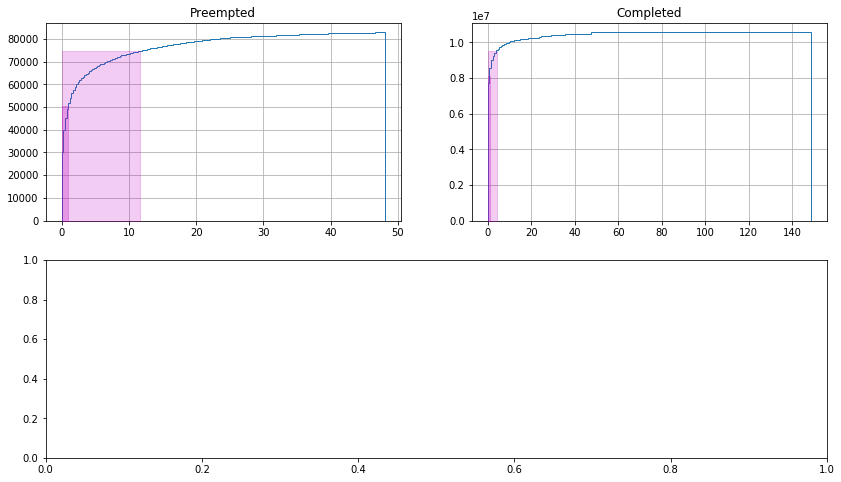

In [60]:
fg = plt.figure(figsize=(14,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
ax3 = fg.add_subplot('212')
#
hhs=[]

for nm, dta,ax in [("Preempted", pr_working, ax1), ("Completed", compl, ax2)]:
    hh = ax.hist(dta['Elapsed']*24., bins=200, cumulative=True,
                  density=False, zorder=5, histtype='step')
    hhs+=[hh]
    #
    y_90=.9*numpy.max(hh[0])
    k_90=numpy.searchsorted(hh[0], y_90)
    #x_90 = .5*(hh[1][k_90]+hh[1][k_90+1])
    x_90 = numpy.mean(hh[1][k_90:k_90+2])
    ax.fill_between([0., x_90], [0.,0.], y_90, color='m', alpha=.2, zorder=11)
    #
    # 1 hour:
    dt=1.
    k1h = numpy.searchsorted(hh[1], dt)
    y1h = numpy.mean(hh[0][k1h-2:k1h])
    ax.fill_between([0., 1.], 0., y1h, color='m', alpha=.25, zorder=10 )

    ax.grid()
    ax.set_title("{}".format(nm))
    #
    print('{}: t_90: {}'.format(nm, x_90))
    print('{}: P(1hr): {}'.format(nm, y1h/numpy.max(hh[0])))
    #
print('** N_completed: {}'.format(len(compl)))
print('** N_pr: {}'.format(len(pr_working)))
#
print('** P(re): ', len(pr_working)/(len(pr_working)+len(compl)))
#
# TODO: total probability distribution of preemption. so basically we want to add the cumulative histograms
#. of preempted and completed.To do that, we have to interpolate the two sets on to the same x-axis.
# a quick estimator is to just multiply by P(preempt).
#ax3.plot()
#print('** ', type(hh[0]))


In [ ]:
print('** ', sacct_mazama.cpu_usage[500:510])
fg = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(sacct_mazama.cpu_usage['time'], sacct_mazama.cpu_usage['N_cpu'], ls='-')

In [ ]:
# print(sacct_mazama.jobs_summary[0:5])
# print(sacct_mazama.jobs_summary.dtype.names)

In [ ]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]))

In [ ]:
#
#cpu_usage = sacct_mazama.active_jobs_cpu()
cpu_usage = sacct_mazama.cpu_usage
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=None)

In [ ]:
# print('** ', len(cpu_usage['time']))
# print('** ** ', sacct_mazama.data[0:5])
# print('** ', sacct_mazama.data.dtype)

In [ ]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [ ]:
print('*** ', sacct_mazama.jobs_summary['End'].shape)
print('*** ', (sacct_mazama.jobs_summary[None])['End'].shape)
print('*** ', (sacct_mazama.jobs_summary[(numpy.random.random(len(sacct_mazama.jobs_summary))>.8)])['End'].shape)

In [ ]:
inst_stats = sacct_mazama.active_cpu_jobs_per_day_hour_report(periodic_projection='polar')
#plt.savefig('{}/figs/jobs_per_{}_all.png'.format(output_path, system_name))

In [ ]:
weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=1000)

daily_hours = sacct_mazama.get_cpu_hours(bin_size=1, n_points=1000)

fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

#ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)
ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*12*24*24, ls='--', marker='',
         lw=3., color='r', label='CPU+GPU')
ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*14*24*24, ls='--', marker='',
         lw=3., color='g', label='CPU nodes')
ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*12*24*8, ls='--', marker='',
         lw=3., color='m',label='9 to 5')
#
ax1.legend(loc=0)
if not os.path.isdir(os.path.join(output_path, 'figs')):
    os.makedirs(os.path.join(output_path, 'figs'))
plt.savefig(os.path.join(output_path, 'figs', 'daily_cpu_hours_all.png'))

In [ ]:
# weekly_hours_LL = sacct_mazama.get_cpu_hours_LL(bin_size=7, n_points=1000)
# daily_hours_LL = sacct_mazama.get_cpu_hours_LL(bin_size=1, n_points=1000)

# fg = plt.figure(figsize=(10,8))
# ax1 = plt.gca()
# ax1.grid()
# #
# ax1.plot(weekly_hours_LL['time'], weekly_hours_LL['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
# ax1.plot(daily_hours_LL['time'], daily_hours_LL['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


# #
# fg.canvas.draw()
# #
# # set ax3 labels to dates:
# # now format the datestrings...
# lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
# #print('*** ', lbls)
# #
# ax1.set_xticklabels(lbls)
# ax1.set_xlabel('Time $t$')
# ax1.set_ylabel('Daily CPU hours')
# ax1.set_title('Daily CPU hours')
# #
# ax1.legend(loc=0)

# #ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)
# ax1.plot(daily_hours['time'][0::len(daily_hours_LL)-1], numpy.ones(2)*12*24*24, ls='--', marker='',
#          lw=3., color='r', label='CPU+GPU')
# ax1.plot(daily_hours['time'][0::len(daily_hours_LL)-1], numpy.ones(2)*14*24*24, ls='--', marker='',
#          lw=3., color='g', label='CPU nodes')
# ax1.plot(daily_hours['time'][0::len(daily_hours_LL)-1], numpy.ones(2)*12*24*8, ls='--', marker='',
#          lw=3., color='m',label='9 to 5')

# # ax1.legend(loc=0)


# # if not os.path.isdir(os.path.join(output_path, 'figs')):
# #     os.makedirs(os.path.join(output_path, 'figs'))
# # plt.savefig(os.path.join(output_path, 'figs', 'daily_cpu_hours_all.png'))

In [ ]:
# how many active nodes do we have? looks like tasks/cpus show up as 1/thread, so 48 per node, so...
n_max = numpy.max(daily_hours['cpu_hours'])
#
n_nodes = n_max/(24.*48.)
#
print('*** n_max={}, n_nodes={}'.format(n_max, n_nodes))
#140000/(24*48)

In [ ]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = sacct_mazama.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = sacct_mazama.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

In [ ]:
zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=(14,10), cpu_usage=None, periodic_projection='polar')

In [ ]:
# compute some distributions:
print('*** ', sacct_mazama.jobs_summary.dtype.names)
run_times = sacct_mazama.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
#ax1a.set_yscale('log')
ax3 = fg.add_subplot('223')
ax4 = fg.add_subplot('224')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, normed=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, normed=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True)
hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [ ]:
print('** ', len(run_times), len(sacct_mazama.jobs_summary['NCPUS']))

In [ ]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(sacct_mazama.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


In [ ]:
wait_stats = sacct_mazama.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

In [ ]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


### Group drill-down stats: Example
- Demo of how to get some sort of PI/group subsets.
- More to come...

In [ ]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in sacct_mazama.jobs_summary['User'] ])
#ix = numpy.array([True for s in sacct_mazama.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
print('** DEBUG: sum(ix={})'.format(numpy.sum(ix)))
#
cpu_weekly_edg = sacct_mazama.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly_edg['time'], cpu_weekly_edg['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly_edg['time'], cpu_weekly_edg['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [ ]:
A = [['a', 'b', 'c'], ['d', 'e'], ['f', 'g', 'h', 'i']]
print(A)
AA = [s for rw in A for s in rw]
#
print('** AA: ', AA)

### All the groups:

In [ ]:
# make some slides, including all the breakdown.
# TODO: wrap this up into a class or function in HPC_lib.
# inputs: SACCT_data_handler object, groups-dict/JSON,  output_path, cosmetics (like line width, etc.)
#
add_all = True
#
if not os.path.isdir(os.path.join(output_path, 'figs')):
    os.makedirs(os.path.join(output_path, 'figs'))

# HPC_tex_obj = hpc_lib.Tex_Slides(Short_title='HPC Analytics', Full_title="HPC Analitics Breakdown for Mazama",
#                         foutname='output/HPC_analytics/HPC_analytics.tex')
HPC_tex_obj = hpc_lib.Tex_Slides(Short_title='HPC Analytics', Full_title="HPC Analitics Breakdown for Mazama",
                        foutname=os.path.join(output_path, 'HPC_analytics.tex') )


#
fig_width=".8"
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All): Daily CPU Hours',
#                                         width=fig_width, fig_path='figs/daily_cpu_hours_all.png')
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All): CPU/Jobs per day/hour', width=fig_width,
#                           fig_path='figs/jobs_per_mazama_all.png')
# print('*** ***')
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All)-2',
#                                         width=fig_width, fig_path='figs/daily_cpu_hours_all.png')

# print('*** * ***')
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All)-3',
#                                         width=fig_width, fig_path='figs/daily_cpu_hours_all.png')
# #
print('keys: ', HPC_tex_obj.project_tex.keys())

#HPC_tex_obj.render()

# Start with a table of weekly usage by group?
#
if groups_fname is None:
    groups={}
    groups['All'] = list(set(sacct_mazama.jobs_summary['User']))
else:
    with open(groups_fname, 'r') as fin:
        groups = json.load(fin)
    #
    if add_all and not "all" in [s.lower() for s in groups.keys()]:
        groups['All'] = list(set([s for rw in groups.values() for s in rw]))

print('keys: ', groups.keys() )
fig_size=tuple((12,9))
for k, (ky,usrs) in enumerate(groups.items()):
    #
    # tex corrected group name:
    grp_tex = ky.replace('_', '\_')
    gpr_tex = ky.replace('\\_', '\_')
    #
    ix = numpy.where([s in usrs for s in sacct_mazama.jobs_summary['User'] ])
    #print('** DEBUG: sum(ix)={} / ix.shape={}'.format(numpy.sum(ix), numpy.shape(ix)) )
    if len(ix)==0:
        print('[{}]:: no records.'.format(ky))
        continue
    #
    #
    #js_sub = numpy.array([tuple(rw) for rw in sacct_mazama.jobs_summary[ix]],
    #                                      dtype=sacct_mazama.jobs_summary.dtype)
    #print('*** js_sub: ', js_sub.shape, js_sub[0:3])
    #
    # this might actually work as intended. now. there were an odd combination of mistakes
    #. causing unpredictable behavior.
    wkly_hrs = sacct_mazama.get_cpu_hours(bin_size=7, n_points=500, IX=ix, verbose=0)
    #
    act_jobs = sacct_mazama.active_jobs_cpu(bin_size=None, t_min=None, ix=ix, verbose=0)
    if len(act_jobs)==0:
        print('Group: {}:: no records.'.format(ky))
        continue
    #
    fg = plt.figure(figsize=fig_size)
    ax1 = plt.subplot('211')
    ax1.grid()
    ax1a = ax1.twinx()
    ax2 = plt.subplot('212', sharex=ax1)
    ax2.grid()
    #
    ax1.plot(act_jobs['time'], act_jobs['N_jobs'], ls='-', lw=2., marker='', label='Jobs', alpha=.5 )
    ax1a.plot(act_jobs['time'], act_jobs['N_cpu'], ls='--', lw=2., marker='', color='m',
              label='CPUs', alpha=.5)
    ax1a.set_title('Group: {}'.format(ky))
    #
    ax2.plot(wkly_hrs['time'], wkly_hrs['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
    #
    ax1.set_ylabel('$N_{jobs}$', size=14)
    ax1a.set_ylabel('$N_{cpu}$', size=14)
    #
    ax1.legend(loc='upper left')
    ax1a.legend(loc='upper right')
    #
    ax2.set_ylabel('Daily CPU hours', size=16)
    #
    fg.canvas.draw()
    #
    # set ax3 labels to dates:
    # now format the datestrings...
    for ax in (ax1,):
        lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax.get_xticklabels()]
        ax.set_xticklabels(lbls)
    #    
    #
    # Save figure and add slide:
    cpu_usage_fig_name=os.path.join('figs', '{}_cpu_usage.png'.format(ky))
    cpu_usage_fig_path=os.path.join(output_path, cpu_usage_fig_name)
    plt.savefig(cpu_usage_fig_path)
    HPC_tex_obj.add_fig_slide(fig_title='{}: CPU/Jobs Requests'.format(grp_tex),
                                        width=fig_width, fig_path=cpu_usage_fig_name)
    print('*** Slide_1 added??:: ', len(HPC_tex_obj.project_tex))
              
    #
    # now, add the active jobs report:
    #jobs_per_name=os.path.join('figs', '{}_jobs_per.png'.format(ky))
    #jobs_per_path=os.path.join(output_path, jobs_per_name)
    #
    zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=fig_size, cpu_usage=act_jobs,foutname=None)
    plt.suptitle('Instantaneous Usage: {}'.format(ky), size=16)
    #
    #
    jobs_per_name=os.path.join('figs', '{}_jobs_per.png'.format(ky))
    jobs_per_path=os.path.join(output_path, jobs_per_name)
    #
    plt.savefig(jobs_per_path)
    HPC_tex_obj.add_fig_slide(fig_title='{}: Periodic Usage'.format(grp_tex),
                                        width=fig_width, fig_path=jobs_per_name)
    #
    print('*** Slide_2 added??:: ', len(HPC_tex_obj.project_tex))
    #
    #if k>2: break
    #HPC_tex_obj.render()
    #
HPC_tex_obj.render()

In [ ]:
print(sacct_mazama.jobs_summary['End'].shape)
xx = sacct_mazama.jobs_summary['End']
print('** ', xx.shape, numpy.ndim(xx))
print('** ** ', xx[numpy.array([0,1,4,45,89,100])].shape)

In [ ]:
if True:
    with open(data_file_name, 'r') as fin:
        header_rw = fin.readline()
        print('*** ', header_rw)

    headers = header_rw.split('|')
    k_group = headers.index('Group')
    k_gid = headers.index('GID')
    #
    
    with open(data_file_name, 'r') as fin:
        for k,rw in enumerate(fin):
            #if 'dunham' in rw: print('** ', rw)
            #if 'dunham' in rw:
            #    rws = rw.split('|')
            #    print('** ', rws[k_group], rws[k_gid])
            if 'Partition_Limit' in rw:
                print('** ', rw)
                k+=1
                if k>10: break



In [ ]:
for rw in zip([1,2,3,4], [5,6,7,8], [9,10,11, 12]):
    print('* ', rw)

In [ ]:
A = numpy.array(numpy.zeros((10,3)), dtype=[('x', '>f8'), ('y', '>f8'), ('z', '>f8')])
print('A ', A)

In [ ]:
# print('** \n', my_tex_obj.get_fig_slide(fig_title='Mazama (All)',
#                                         width=.8, fig_path='{}/daily_cpu_hours_all.png'.format(output_path)))

In [ ]:
#out_path = 'output/mazama_analytics'
print('*** cleaning up old out_path...')
sp_status = subprocess.run(['rm', '-rf', output_path])
print('*** out_path (should be) removed: ', sp_status)
#
mazama_report = hpc_lib.SACCT_groups_analyzer_report(out_path=output_path, groups=groups_fname,
                                            tex_filename='Mazama_HPC_analytics.tex',
                                            SACCT_obj=sacct_mazama, max_rws=None)

In [ ]:
print('** ', sacct_mazama.jobs_summary.dtype.names)


In [ ]:
print('** ', sacct_mazama.jobs_summary['AllocGRES'][0:100] )

In [ ]:
sacct_mazama.jobs_summary.dtype.names